# Trabalho Prático 1
**Grupo 22**

Alexis Correia - A102495 <br>
João Fonseca - A102512


## Exercício 2
Um sistema de tráfego  é representado por um grafo orientado ligado. Os nodos denotam pontos de acesso e  os arcos denotam vias de comunicação só com um sentido .  O grafo tem de ser ligado: entre cada par de nodos  $(n_1,n_2)$ tem de existir um caminho $n_1 -> n_2$ e um caminho $n_2 -> n_1$.

1. Gerar aleatoriamente o grafo com  $N \in \{6..10\}$  nodos e com ramos verificando:
    1. Cada nodo tem um número aleatório de descendentes $d \in \{0..3\}$, cujos destinos são também gerados aleatoriamente.
    2. Se  existirem “loops”  ou destinos repetidos, deve-se gerar outro grafo.
    
2. Pretende-se fazer  manutenção interrompendo  determinadas vias. Determinar o maior número de vias que é possível remover mantendo o grafo ligado.

In [1]:
#Inicialização

import networkx as nx
import random

{0: [2], 1: [6, 5], 2: [6], 3: [8], 4: [0, 6], 5: [8], 6: [8, 5], 7: [3, 6], 8: [2, 1]}


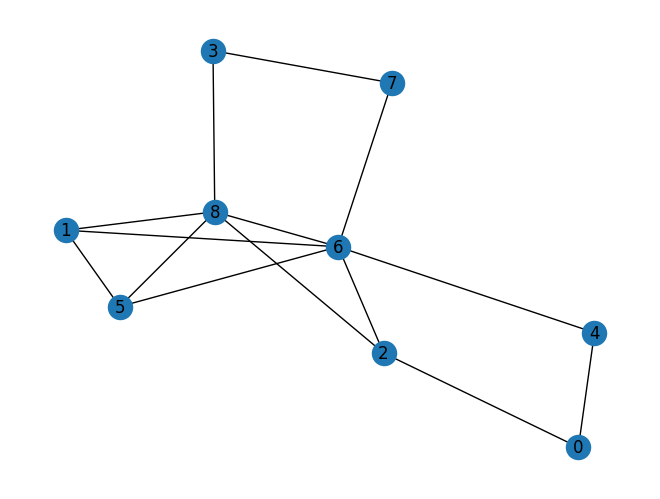

In [6]:
def converte(adj):
    graph = nx.Graph()
    for n in adj.keys():
        graph.add_node(n)
        for i in adj[n]:
            graph.add_edge(n, i)
    return graph

random.seed(None)

def cria_adj(N):
    adj = {}
    for n in range(N):
        adj[n] = []
        
    for n in range(N):
        adj[n] = []
        for i in range(random.randint(0,3)):
            d = random.randint(0,N-1)
            if d == n or (d in adj[n]) or (n in adj[d]):
                #adj[n] = []
                continue
            else:
                adj[n].append(d)
    
    return adj

N = 9 #6..10
adj = cria_adj(N)
print(adj)

G = converte(adj)
nx.draw(G, with_labels=True)